In [197]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from tensorflow import keras
import random as rand
import cv2
import pandas as pd
np.set_printoptions(suppress=True)

x_digit = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
y_digit = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

print(x_digit.shape, y_digit.shape)
BATCH_SIZE = 512
TRAIN_SIZE = 5120
TEST_SIZE = 5000
EPOCHS = 100
OUTER_IMG_SZ = 152

(60000, 28, 28) (60000,)


In [198]:
### Generate train and test data using mnist set with NUM_SIZE digits
GRID_SIDE = 9

image_dict = [[] for i in range(10)]
for digit,image in zip(y_digit, x_digit):
    image_dict[digit].append(image)

In [199]:
def normalize(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    return (arr - mn)/(mx - mn)

In [200]:
def arr_stats(arr):
    mn = np.amin(arr) 
    mx = np.amax(arr) 
    rng = np.ptp(arr) 
    varience = np.var(arr) 
    sd = np.std(arr) 
    print("Measures of Dispersion") 
    print("Minimum =", mn) 
    print("Maximum =", mx) 
    print("Range =", rng) 
    print("Varience =", varience) 
    print("Standard Deviation =", sd) 
    print(arr)
    plt.imshow(arr)

In [201]:
class SudokuPuzzleGenerator(keras.utils.Sequence):
    
    def __init__(self, length_of_set, batch_size=BATCH_SIZE):
        self.batch_size = batch_size
        self.length_of_set = length_of_set
        self.epoch_count = 0.0
    
    def __len__(self):
        'Denotes the number of batches per epoch 10k/128'
        ret = self.length_of_set // self.batch_size
        #print("Returning length as " + str(ret))
        return ret

    def __getitem__(self, index):
        'Generate one batch of data'
        #print("Getting item for index " + str(index))
        # Generate indexes of the batch
        #print("using batch_size " + str(self.batch_size))
        x, y = self.gen_test_data(self.batch_size)
        #print("Shapes of returned ", x.shape, y.shape)
        return x, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.epoch_count += 1.0
        #print("An epoch ended >>>>>>> xxxxxxx >>>>>> qqq >>>>")
    
    
    def warp_image(self, img, offsets, puzzle_size):
        top = offsets[0]
        left = offsets[1]
        bottom = offsets[2]
        right = offsets[3]
        
        top_left = [left, top]
        bottom_left = [left, bottom]
        top_right = [right, top]
        bottom_right = [right, bottom]
        
        #print("\nInput offsets: " + str(offsets))
              
        initial_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        #print("\nInput points: " + str(initial_pts))

    
        #translate each offset by upto 30% of the puzzle_size taking care not to go out of OUTER_IMG_SZ
        
        puzzle_size_percent = int(puzzle_size * 0.1)
        
        max_trans_top = min(top, puzzle_size_percent)
        
        max_trans_left = min(left, puzzle_size_percent)
        
        max_trans_bottom = min(OUTER_IMG_SZ - bottom, puzzle_size_percent)
        
        max_trans_right = min(OUTER_IMG_SZ - right, puzzle_size_percent)
        
        top_left = [left + rand.randint(-max_trans_left, max_trans_left), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_left = [left + rand.randint(-max_trans_left, max_trans_left), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        top_right = [right + rand.randint(-max_trans_right, max_trans_right), top + rand.randint(-max_trans_top, max_trans_top)]
        bottom_right = [right + rand.randint(-max_trans_right, max_trans_right), bottom + rand.randint(-max_trans_bottom, max_trans_bottom)]
        
        dest_pts = np.float32([top_left, bottom_left, top_right, bottom_right])
        
        warp_matrix = cv2.getPerspectiveTransform(initial_pts, dest_pts)
        warped_img = cv2.warpPerspective(img, warp_matrix, (OUTER_IMG_SZ, OUTER_IMG_SZ), borderMode = cv2.BORDER_REFLECT_101 )
        
        warped_offsets = [top, left, bottom,right]
                
        #print("\nwarped offsets: " + str(warped_offsets))
        #print("\nwarped points: " + str(dest_pts))
        #print("\nwarped points2: " , dest_pts.reshape((8)).shape)

        
        return warped_img, dest_pts.reshape(8)

    def process_img(self, img):
        #arr_stats(img)
        return img
    
    def gen_test_data(self, num_data):
        x_data, y_data = np.zeros((num_data, OUTER_IMG_SZ , OUTER_IMG_SZ)), np.zeros((num_data, 8))
        #x_data, y_data = 100 * np.random.randn(num_data, OUTER_IMG_SZ , OUTER_IMG_SZ), np.zeros((num_data, 8))
        for i in range(num_data):
            #pick a random size so that the grid is at least 50% of the overall image
            border_sz = rand.randint(1,2)
            digit_sz = rand.randint(OUTER_IMG_SZ//(2 * GRID_SIDE), OUTER_IMG_SZ//GRID_SIDE) - 2 * border_sz
            border_digit_sz  = digit_sz + 2 * border_sz
            grid_size = GRID_SIDE * (border_digit_sz)
            #pick random offsets so image doesn't go off screen
            x_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            y_offset = rand.randint(0, OUTER_IMG_SZ - grid_size)
            offsets = [y_offset, x_offset, y_offset + grid_size, x_offset + grid_size]
            x_data[i] = np.random.randint(0, 255, size = ((OUTER_IMG_SZ , OUTER_IMG_SZ)))
            clr = list(np.random.choice(range(256), size=3))
            for k in range(GRID_SIDE**2):
                #rand_digit = rand.randint(0,9)
                #rand_img = rand.choice(image_dict[rand_digit])
                rand_img = np.random.randint(0,255, size = (digit_sz, digit_sz))
                #rand_img = cv2.resize(rand_img, (digit_sz, digit_sz))
                #if rand_digit == 0 : rand_img = np.zeros((digit_sz, digit_sz))
                rand_img = cv2.copyMakeBorder(rand_img, border_sz,border_sz,border_sz,border_sz, cv2.BORDER_CONSTANT, value = [int(clr[0]),int(clr[1]),int(clr[2])])
                r = k//GRID_SIDE
                c = k % GRID_SIDE
                x_data[i, y_offset + r*border_digit_sz:y_offset + (r+1)*border_digit_sz, x_offset + border_digit_sz*c:x_offset + border_digit_sz*(c+1)] = rand_img
                
            x_data[i], y_data[i] = self.warp_image(x_data[i], offsets, grid_size)
            x_data[i] = self.process_img(x_data[i])
        x_data = normalize(x_data)
        return x_data, y_data
    

In [202]:
def visualize(img, coords):
   
    circle1 = plt.Circle((coords[0],coords[1]) , 5, color='r')
    circle2 = plt.Circle((coords[2],coords[3]) , 5, color='r')
    circle3 = plt.Circle((coords[4],coords[5]) , 5, color='r')
    circle4 = plt.Circle((coords[6],coords[7]) , 5, color='r')
    
    
    plt.gca().add_patch(circle1)
    plt.gca().add_patch(circle2)
    plt.gca().add_patch(circle3)
    plt.gca().add_patch(circle4)
    
        
    plt.imshow(img)
    plt.show()

(152, 152)


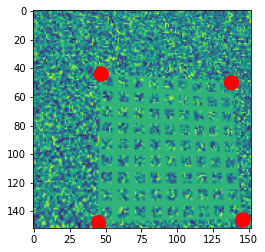

Measures of Dispersion
Minimum = 0.024345503089374262
Maximum = 0.969528616083063
Range = 0.9451831129936887
Varience = 0.02043382157319344
Standard Deviation = 0.1429469187257754
[[0.71035988 0.52156974 0.55353186 ... 0.63680816 0.81238182 0.88173699]
 [0.70530884 0.5344027  0.49309074 ... 0.67249102 0.81205972 0.81593167]
 [0.48894388 0.51887466 0.56705625 ... 0.60932714 0.73558882 0.73602347]
 ...
 [0.35270214 0.28896807 0.21897185 ... 0.64850265 0.64387214 0.49577794]
 [0.47473185 0.36733512 0.25662578 ... 0.6517038  0.65265097 0.50400489]
 [0.56147311 0.48522716 0.325501   ... 0.64745577 0.65833135 0.53757468]]


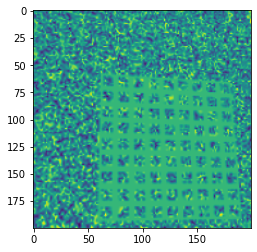

In [203]:
gen = SudokuPuzzleGenerator(1)
x,y = gen.gen_test_data(1)
print(x[0].shape)
visualize(x[0], y[0])
plt.show()
arr_stats(cv2.resize(x[0],(200,200)))
#print(x)

In [297]:
act = 'relu'
pad = 'same'
strd = 1
filter_size_mul = 7
krnl_sz = 7
input_layer = tf.keras.Input(shape = (OUTER_IMG_SZ, OUTER_IMG_SZ,1))

branch_1 = tf.keras.layers.Conv2D(filters = 2, kernel_size=(OUTER_IMG_SZ//2, 10), activation = act, padding = 'valid', strides = (OUTER_IMG_SZ//2 ,int(10)))(input_layer)
branch_1 = tf.keras.layers.Flatten()(branch_1)

branch_2 = tf.keras.layers.Conv2D(filters = 2, kernel_size=(10, OUTER_IMG_SZ//2), activation = act, padding = 'valid', strides = (10, OUTER_IMG_SZ//2))(input_layer)
branch_2 = tf.keras.layers.Flatten()(branch_2)

branch_3 = tf.keras.layers.Conv2D(filters = 2, kernel_size=(OUTER_IMG_SZ, 10), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_3 = tf.keras.layers.Flatten()(branch_3)

branch_4 = tf.keras.layers.Conv2D(filters = 2, kernel_size=(10, OUTER_IMG_SZ), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_4 = tf.keras.layers.Flatten()(branch_4)

branch_5 = tf.keras.layers.Conv2D(filters = 2, kernel_size=(OUTER_IMG_SZ//2, OUTER_IMG_SZ//2), activation = act, padding = 'valid', strides = 10)(input_layer)
branch_5 = tf.keras.layers.Flatten()(branch_5)

common = tf.keras.layers.concatenate([branch_1, branch_2, branch_3, branch_4, branch_5], axis=-1)


#_ = tf.keras.layers.MaxPool2D()(_)
# = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.Conv2D(filters=filter_size_mul*4, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.MaxPool2D()(_)
# = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
# = tf.keras.layers.Conv2D(filters=filter_size_mul*8, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 

'''
_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*5, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.AveragePooling2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*6, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 

_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*16, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_) 
_ = tf.keras.layers.Conv2D(filters=filter_size_mul*32, kernel_size=krnl_sz, activation = act, padding = pad, strides = strd)(_)
_ = tf.keras.layers.MaxPool2D()(_)
'''

_ = tf.keras.layers.Flatten()(common)
_ = tf.keras.layers.Dense(308, activation=act)(_)
_ = tf.keras.layers.Dense(308, activation=act)(_)
_ = tf.keras.layers.Dense(150, activation=act)(_)
_ = tf.keras.layers.Dense(50, activation=act)(_)
_ = tf.keras.layers.Dense(16, activation=act)(_)
output_layers = tf.keras.layers.Dense(8, name="edges")(_)


def distance_between_pts_loss(y_true, y_pred):
    dist = []
    for i in range(0, 4):
        true_px = y_true[:, i * 2:i * 2 + 1]
        pred_px = y_pred[:, i * 2:i * 2 + 1]
        true_py = y_true[:, i * 2 + 1:i * 2 + 2]
        pred_py = y_pred[:, i * 2 + 1:i * 2 + 2]
        dist.append (tf.math.sqrt(tf.math.square(tf.math.subtract(true_px,pred_px)) + tf.math.square(tf.math.subtract(true_py, pred_py))))
    return tf.math.reduce_max(dist)
    '''
    print(y_true)
    print("\n---")
    print(y_pred)
    return tf.math.reduce_mean(tf.math.subtract(y_true, y_pred))
    '''

loss_fns = tf.keras.losses.MeanSquaredError()

model = tf.keras.Model(inputs=input_layer, outputs = output_layers, name="digit_recognizer")
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.2),
             loss = distance_between_pts_loss,
             metrics = ['accuracy'] )
model.summary()

#model = keras.models.load_model('models/grid_detector_with_noise')


Model: "digit_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 152, 152, 1) 0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 2, 15, 2)     1522        input_46[0][0]                   
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 15, 2, 2)     1522        input_46[0][0]                   
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 1, 15, 2)     3042        input_46[0][0]                   
___________________________________________________________________________________

In [298]:
training_gen = SudokuPuzzleGenerator(TRAIN_SIZE)
validation_gen = SudokuPuzzleGenerator(TEST_SIZE)

In [299]:
model.fit(x = training_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
10/10 [==============================] - 77s 8s/step - loss: 541.3587 - accuracy: 0.2215
Epoch 2/100
10/10 [==============================] - 80s 8s/step - loss: 214.6299 - accuracy: 0.2076
Epoch 3/100
10/10 [==============================] - 84s 8s/step - loss: 214.2601 - accuracy: 0.2024
Epoch 4/100
10/10 [==============================] - 94s 9s/step - loss: 213.7639 - accuracy: 0.1

KeyboardInterrupt: 

In [211]:
model.evaluate(x=validation_gen, y=None, verbose=1)

9/9 [==============================] - 4s 441ms/step - loss: 8.3149 - accuracy: 0.4028


[8.314901351928711, 0.4027777910232544]

In [210]:
model.save('models/grid_detector_custom_loss_reduce_max')


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: models/grid_detector_custom_loss_deeper/assets


(1, 152, 152) (1, 8)


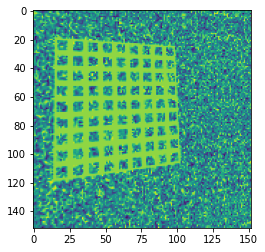

[[ 15.  19.  14. 120.  99.  25. 103. 107.]]
[[ 12.465855  23.447845  12.851445 117.314964 101.046745  24.162743
  100.39637  115.453514]]


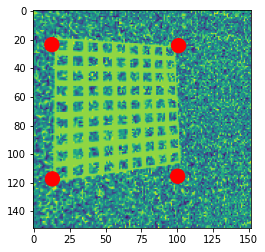

In [273]:
x,y = training_gen.gen_test_data(1)
#_, x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)
print(x.shape, y.shape)
plt.imshow(x[0])
plt.show()
print(y)
pred  = model.predict(x)
print(pred)
visualize(x[0], pred[0])
matplotlib.image.imsave('saved.png', x[0])

In [ ]:
dgen = tf.keras.preprocessing.image.ImageDataGenerator()
tst_img = dgen.apply_transform(x.reshape(512,512,1) , {'shear':5, 'theta' : -25})
plt.imshow(tst_img.reshape(512,512))
model.predict(tst_img.reshape(1,512,512))

In [1]:
visualize(tst_img, model.predict(tst_img.reshape(1,512,512))[0])

NameError: name 'visualize' is not defined

(371, 402)


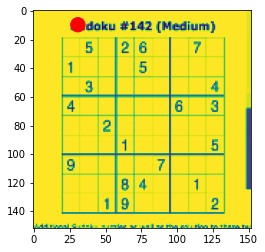

[ 30.65623    9.549436  27.9961   249.40921  266.59338    8.043007
 269.92847  248.87859 ]


0

In [278]:
def from_img():
    img = cv2.imread('8.png', cv2.IMREAD_GRAYSCALE)
    print(img.shape)
    img = cv2.resize(img, (OUTER_IMG_SZ,OUTER_IMG_SZ))
    img = normalize(img)
    visualize(img, model.predict(img.reshape(1,OUTER_IMG_SZ,OUTER_IMG_SZ))[0])
    print(model.predict(img.reshape(1,OUTER_IMG_SZ,OUTER_IMG_SZ))[0])
    #arr_stats(cv2.resize(img, (200,200)))
    return 0
from_img()